In [ ]:
import pandas as pd
import numpy as np

FILE_PATH        = "boots 1(in).csv"
DATE_COL         = "Sample Date"
WARD_COL         = "ward"
FIRST_DRAW_COL   = "1st Draw"
BOOT_ITERATIONS  = 10_000
RANDOM_SEED      = 42

# 1. Load the data
db = pd.read_csv(
    FILE_PATH,
    usecols=[DATE_COL, WARD_COL, FIRST_DRAW_COL]
)

# 2. Convert date column to datetime and create a Season column
db[DATE_COL] = pd.to_datetime(db[DATE_COL], errors="coerce")

def month_to_season(month: int) -> str:
    """Return the climatological season for a month number (1-12)."""
    if month in (12, 1, 2):
        return "Winter"
    if month in (3, 4, 5):
        return "Spring"
    if month in (6, 7, 8):
        return "Summer"
    return "Fall"

db["Season"] = db[DATE_COL].dt.month.apply(month_to_season)

# 3. Define a generic bootstrap helper
rng = np.random.default_rng(RANDOM_SEED)

def bootstrap_mean(data: np.ndarray,
                   n_iterations: int = BOOT_ITERATIONS) -> tuple[float, float, float]:
    """
    Return (mean, 2.5 %-tile, 97.5 %-tile) from bootstrap on *data*.
    """
    n = data.size

    idx = rng.integers(0, n, size=(n_iterations, n))
    samples = data[idx]
    means   = samples.mean(axis=1)
    mean    = means.mean()
    lower   = np.percentile(means, 2.5)
    upper   = np.percentile(means, 97.5)
    return mean, lower, upper

# 4. Loop over Ward × Season and collect results
records: list[dict] = []

for (ward, season), group in db.groupby([WARD_COL, "Season"]):
    values = group[FIRST_DRAW_COL].dropna().to_numpy(dtype=float)
    if values.size < 2:          # too little data to bootstrap
        continue
    mean, lo, hi = bootstrap_mean(values)
    records.append({
        "Ward": ward,
        "Season": season,
        "N": values.size,
        "Bootstrap Mean": mean,
        "CI 2.5%": lo,
        "CI 97.5%": hi
    })

# 5. Build a tidy DataFrame of results
results = (
    pd.DataFrame(records)
      .sort_values(["Ward", "Season"])
      .reset_index(drop=True)
)

# 6. Display in console (or save / plot as needed)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
print("\nBootstrap results (mean ± 95 % CI) for each Ward × Season:")
print(results.to_string(index=False))



Bootstrap results (mean ± 95 % CI) for each Ward × Season:
  Ward Season   N  Bootstrap Mean  CI 2.5%  CI 97.5%
 1.000   Fall 170           1.866    1.402     2.411
 1.000 Spring 140           2.077    1.447     2.972
 1.000 Summer 242           3.142    1.749     5.493
 1.000 Winter 145           1.942    1.409     2.588
 2.000   Fall 154           1.632    1.238     2.068
 2.000 Spring  83           1.878    1.425     2.402
 2.000 Summer 161           1.881    1.417     2.417
 2.000 Winter  97           1.010    0.762     1.288
 3.000   Fall  66           1.084    0.646     1.658
 3.000 Spring  36           1.779    0.990     2.846
 3.000 Summer  81           1.561    1.019     2.204
 3.000 Winter  43           1.111    0.692     1.753
 4.000   Fall  82           2.529    1.779     3.377
 4.000 Spring  59          16.953    2.668    41.359
 4.000 Summer  90           2.171    1.509     3.048
 4.000 Winter  68           1.834    1.278     2.509
 5.000   Fall 139           2.078    1.

        Q1 (25th pct)  Q3 (75th pct)
Season                              
Winter           0.50           3.80
Spring           1.10           4.00
Summer           0.50           4.30
Fall             0.50           4.40
Winter: mean = 4.16 ppb (95% CI 3.62–4.79), 90th = 6.55 ppb (95% CI 6.20–7.00)
Spring: mean = 4.26 ppb (95% CI 3.82–4.78), 90th = 6.72 ppb (95% CI 6.40–7.00)
Summer: mean = 4.57 ppb (95% CI 4.15–5.05), 90th = 7.54 ppb (95% CI 7.20–7.80)
Fall: mean = 5.00 ppb (95% CI 4.31–5.81), 90th = 7.55 ppb (95% CI 7.30–7.90)


<ipython-input-1-c3b350a4ee37>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


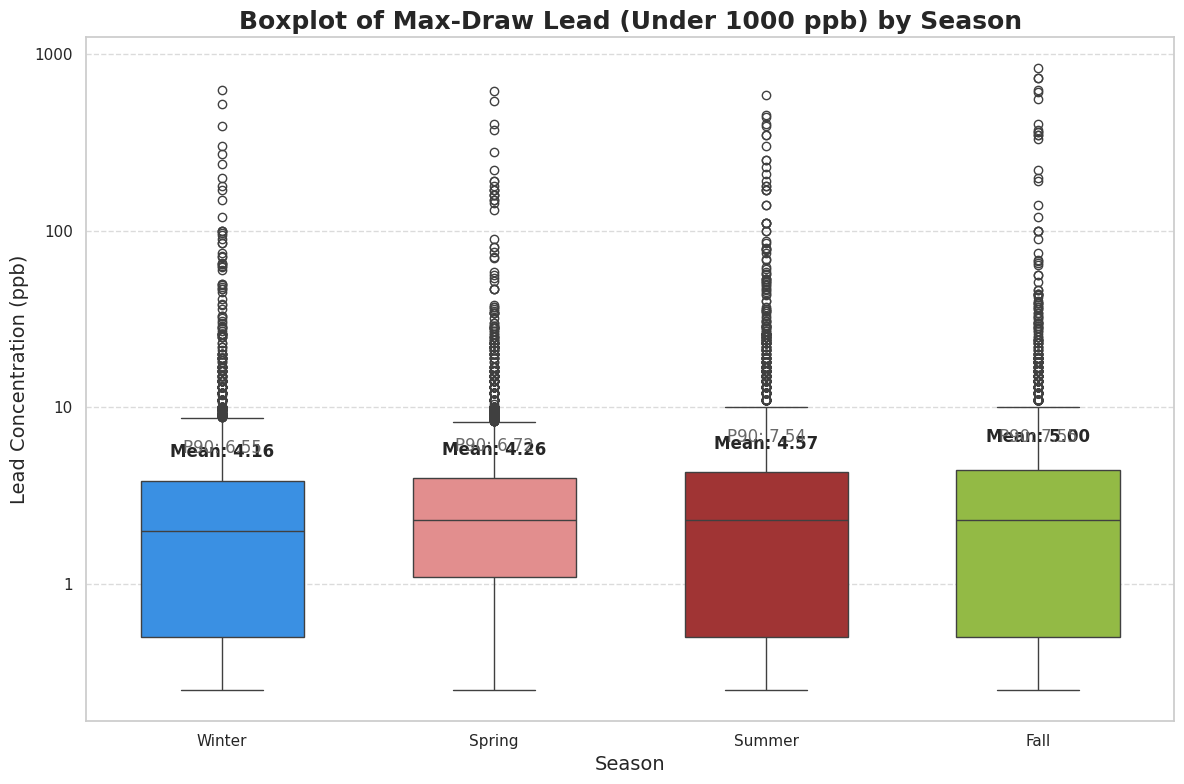

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path     = 'boots 1(in).csv'
dates_col     = 'Sample Date'
first_draw_col = '1st Draw'

# 1. Load & preprocess
db = pd.read_csv(file_path, usecols=[dates_col, first_draw_col])
db[dates_col] = pd.to_datetime(db[dates_col])

def get_season(month):
    if month in [12,1,2]:   return 'Winter'
    if month in [3,4,5]:    return 'Spring'
    if month in [6,7,8]:    return 'Summer'
    return 'Fall'

db['Season'] = db[dates_col].dt.month.apply(get_season)
db_filtered = db[db[first_draw_col] < 1000].copy()

# 2. Bootstrap helper
def bootstrap(data, n_iterations=10000, statistic=np.mean):
    arr = np.array(data)
    n   = len(arr)
    return np.array([
        statistic(np.random.choice(arr, size=n, replace=True))
        for _ in range(n_iterations)
    ])

# 3. Compute mean & 90th-pct for each season
order = ['Winter','Spring','Summer','Fall']
season_stats = {}

for season, group in db_filtered.groupby('Season'):
    vals = group[first_draw_col].dropna().values
    if len(vals) < 2:
        continue

    # bootstrap mean
    boot_means = bootstrap(vals, statistic=np.mean)
    m_est      = boot_means.mean()
    m_lo, m_hi = np.percentile(boot_means, [2.5, 97.5])

    # bootstrap 90th percentile
    boot_q90   = bootstrap(vals, statistic=lambda x: np.percentile(x, 90))
    p90_est    = boot_q90.mean()
    p90_lo, p90_hi = np.percentile(boot_q90, [2.5, 97.5])

    season_stats[season] = {
        'mean':      m_est,
        'ci_lower':  m_lo,
        'ci_upper':  m_hi,
        'p90':       p90_est,
        'p90_lo':    p90_lo,
        'p90_hi':    p90_hi
    }
# ---- Quartile table -------------------------------------------------
quartile_table = (
    db_filtered
    .groupby('Season')[first_draw_col]
    .quantile([0.25, 0.75])          # 25th and 75th percentiles
    .unstack(level=1)                # pivot percentiles into columns
    .rename(columns={0.25: 'Q1 (25th pct)', 0.75: 'Q3 (75th pct)'})
    .reindex(order)                  # keep Winter-Spring-Summer-Fall order
)

print(quartile_table.to_string(float_format="%.2f"))

# 4. Print results
for season in order:
    stats = season_stats.get(season)
    if not stats:
        continue
    print(f"{season}: mean = {stats['mean']:.2f} ppb "
          f"(95% CI {stats['ci_lower']:.2f}–{stats['ci_upper']:.2f}), "
          f"90th = {stats['p90']:.2f} ppb "
          f"(95% CI {stats['p90_lo']:.2f}–{stats['p90_hi']:.2f})")

# 5. Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))

sns.boxplot(
    x= 'Season', y=first_draw_col, data=db_filtered,
    palette={'Winter':'dodgerblue','Spring':'lightcoral',
             'Summer':'firebrick','Fall':'yellowgreen'},
    order=order, width=0.6
)

plt.yscale('log')
plt.yticks([1,10,100,1000], ['1','10','100','1000'])
plt.title("Boxplot of Max-Draw Lead (Under 1000 ppb) by Season",
          fontsize=18, fontweight='bold')
plt.xlabel("Season", fontsize=14)
plt.ylabel("Lead Concentration (ppb)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 6. Annotate mean & 90th percentile
for season in order:
    stats = season_stats.get(season)
    if not stats:
        continue
    # mean above the mean line
    plt.text(
        season,
        stats['mean'] * 1.2,
        f"Mean: {stats['mean']:.2f}",
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )
    # P90 just below the P90 line
    plt.text(
        season,
        stats['p90'] * 0.8,
        f"P90: {stats['p90']:.2f}",
        ha='center', va='bottom', fontsize=12, color='dimgray'
    )

plt.tight_layout()
plt.show()

<ipython-input-7-e96d42234019>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['Month'] = db[dates_col].dt.month_name()


Raw max = 10000.00 ppb
Samples >1000 ppb: 17
  January: mean=3.30, 95% CI=(2.90, 3.84)
 February: mean=5.17, 95% CI=(4.29, 6.19)
    March: mean=4.20, 95% CI=(3.52, 5.02)
    April: mean=3.53, 95% CI=(3.21, 3.91)
      May: mean=3.77, 95% CI=(3.33, 4.27)
     June: mean=4.38, 95% CI=(3.89, 4.93)
     July: mean=4.76, 95% CI=(4.20, 5.42)
   August: mean=4.58, 95% CI=(4.04, 5.18)
September: mean=4.45, 95% CI=(3.89, 5.14)
  October: mean=4.27, 95% CI=(3.69, 4.96)
 November: mean=5.05, 95% CI=(4.12, 6.11)
 December: mean=4.45, 95% CI=(3.64, 5.53)


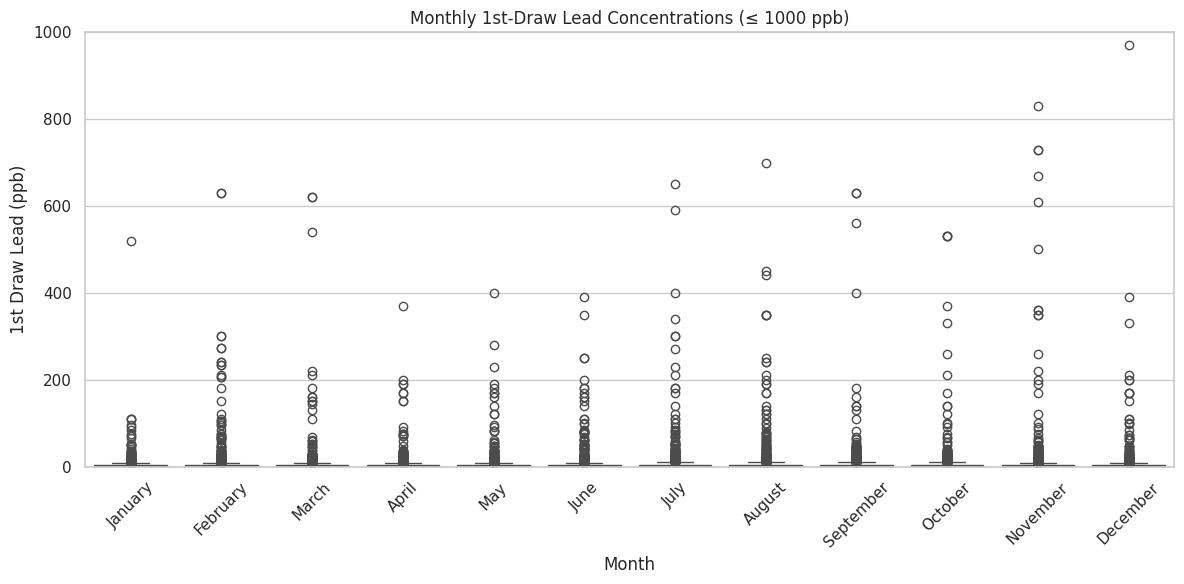

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parameters ---
file_path      = 'boots 1(in).csv'
dates_col      = 'Sample Date'
first_draw_col = '1st Draw'

# --- Load & parse dates ---
db = pd.read_csv(file_path, usecols=[dates_col, first_draw_col])
db[dates_col] = pd.to_datetime(db[dates_col])

# --- Ensure numeric and drop non‑numeric entries ---
db[first_draw_col] = pd.to_numeric(db[first_draw_col], errors='coerce')
db = db.dropna(subset=[first_draw_col])

# --- Add Month column ---
db['Month'] = db[dates_col].dt.month_name()

# --- Report raw max & how many >1000ppb ---
raw_max     = db[first_draw_col].max()
count_over  = (db[first_draw_col] > 1000).sum()  # Change this to >1000 instead of >15
print(f"Raw max = {raw_max:.2f} ppb")
print(f"Samples >1000 ppb: {count_over}")

# --- Filter out everything above 1000 ppb ---
db_filtered = db[db[first_draw_col] <= 1000].copy()  # Change this filter to <= 1000

# --- (Optional) Compute monthly bootstrap means & 95% CIs ---
def bootstrap(arr, n_iter=10000):
    arr = np.array(arr)
    n   = len(arr)
    out = []
    for _ in range(n_iter):
        samp = np.random.choice(arr, size=n, replace=True)
        out.append(np.mean(samp))
    return np.array(out)

month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

for m in month_order:
    grp = db_filtered.loc[db_filtered['Month'] == m, first_draw_col].values
    if len(grp) < 2:
        continue
    boots = bootstrap(grp)
    print(f"{m:>9}: mean={boots.mean():.2f}, "
          f"95% CI=({np.percentile(boots,2.5):.2f}, "
          f"{np.percentile(boots,97.5):.2f})")

# Plot the data with lead levels below 1000 ppb
plt.figure(figsize=(12,6))
sns.boxplot(
    x='Month',
    y=first_draw_col,
    data=db_filtered,
    order=month_order,
    showfliers=True        # Now you’ll actually see points up near 1000
)
plt.ylim(0, 1000)  # Set the upper limit for the y-axis to 1000 ppb
plt.ylabel('1st Draw Lead (ppb)')
plt.title("Monthly 1st‑Draw Lead Concentrations (≤ 1000 ppb)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

file_path = 'boots 1(in).csv'
dates_col = 'Sample Date'
first_draw_col = '1st Draw'

db = pd.read_csv(file_path, usecols=[dates_col, first_draw_col])

# Convert the 'Sample Date' column to datetime
db[dates_col] = pd.to_datetime(db[dates_col])

# Ensure that '1st Draw' column is numeric and drop any rows with NaN values
db[first_draw_col] = pd.to_numeric(db[first_draw_col], errors='coerce')
db = db.dropna(subset=[first_draw_col])

# Filter the data for the date range June 1 to September 30 for each year
start_date = '06-01'
end_date = '09-30'

# Add a year column for grouping
db['Year'] = db[dates_col].dt.year

# Initialize a dictionary to store the 90th percentiles for each year
q_90_by_year = {}

# Loop through each unique year in the dataset
for year in db['Year'].unique():
    # Filter the data for the given year and date range
    db_year = db[(db['Year'] == year) &
                 (db[dates_col].dt.month >= 6) &
                 (db[dates_col].dt.month <= 9)]

    # Calculate the 90th percentile for the filtered data
    q_90 = np.percentile(db_year[first_draw_col], 90)

    # Store the result in the dictionary
    q_90_by_year[year] = q_90

# Print the 90th percentiles for each year
for year, q_90 in q_90_by_year.items():
    print(f"The 90th percentile (q_90) of lead levels for {year} from June 1 to September 30 is {q_90:.2f} ppb")


The 90th percentile (q_90) of lead levels for 2018 from June 1 to September 30 is 6.10 ppb
The 90th percentile (q_90) of lead levels for 2020 from June 1 to September 30 is 6.30 ppb
The 90th percentile (q_90) of lead levels for 2019 from June 1 to September 30 is 7.60 ppb
The 90th percentile (q_90) of lead levels for 2016 from June 1 to September 30 is 7.90 ppb
The 90th percentile (q_90) of lead levels for 2024 from June 1 to September 30 is 6.20 ppb
The 90th percentile (q_90) of lead levels for 2021 from June 1 to September 30 is 8.30 ppb
The 90th percentile (q_90) of lead levels for 2022 from June 1 to September 30 is 8.59 ppb
The 90th percentile (q_90) of lead levels for 2017 from June 1 to September 30 is 7.26 ppb
The 90th percentile (q_90) of lead levels for 2023 from June 1 to September 30 is 8.50 ppb


<ipython-input-11-45096ea3052e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['Year'] = db[dates_col].dt.year
